## Deep Causal Variational Inference

### Introduction:
To train a supervised variational autoencoder using Deepmind's [dSprites](https://github.com/deepmind/dsprites-dataset) dataset.

dSprites is a dataset of sprites, which are 2D shapes procedurally generated from 5 ground truth independent "factors." These factors are color, shape, scale, rotation, x and y positions of a sprite.

All possible combinations of these variables are present exactly once, generating N = 737280 total images.

Factors and their values:

* Shape: 3 values {square, ellipse, heart}
* Scale: 6 values linearly spaced in (0.5, 1)
* Orientation: 40 values in (0, 2$\pi$)
* Position X: 32 values in (0, 1)
* Position Y: 32 values in (0, 1)


Further, the objective of any generative model is essentially to capture underlying data generative factors, the disentangled representation would mean a single latent unit being sensitive to variations in single generative factors

## Goal
The goal is to apply counterfactual queries on our dataset and observe the reconstructed images and results

Reference 

[Structured Disentangled Representation](https://arxiv.org/pdf/1804.02086.pdf)

### Dependencies

In [0]:
!pip install -r '/requirements.txt'

Requirement already up-to-date: pydrive in /usr/local/lib/python3.6/dist-packages (1.3.1)


In [0]:
# LOADING NECESSARY LIBRARIES

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import os
from collections import defaultdict

import torch
import torch.nn as nn

from tqdm import tqdm
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, EmpiricalMarginal
from pyro.optim import Adam, SGD
import torch.distributions.constraints as constraints

# Change figure aesthetics

%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#to utilize GPU capabilities

USE_CUDA = True
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

In [1]:
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### GPU Allocation

In [0]:
# Hack to get all available GPU ram.

import tensorflow as tf
tf.test.gpu_device_name()

# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=05655d06088c2d158f158887b0db72f5680c41953aef1078718bf24757cd9ce5
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 24.3 GB  | Proc size: 3.3 GB
GPU RAM Free: 15477MB | Used: 803MB | Util   5% | Total 16280MB


### Encoder and Decoder

In [0]:
class Encoder(nn.Module):
	"""
    MLPs (multi-layered perceptrons or simple feed-forward networks)
    where the provided activation parameter is used on every linear layer except
    for the output layer where we use the provided output_activation parameter
	"""
	def __init__(self, image_dim, label_dim, z_dim):
		super(Encoder, self).__init__()
		#setup image and label dimensions from the dataset
		self.image_dim = image_dim
		self.label_dim = label_dim
		self.z_dim = z_dim
		# setup the three linear transformations used
		self.fc1 = nn.Linear(self.image_dim+self.label_dim, 1000)
		self.fc2 = nn.Linear(1000, 1000)
		self.fc31 = nn.Linear(1000, z_dim)  # mu values
		self.fc32 = nn.Linear(1000, z_dim)  # sigma values
		# setup the non-linearities
		self.softplus = nn.Softplus()

	#Explaination: xs:- shape: [1, 4096] flattened 64*64 image; ys:- shape[1, 114] flattended one hot encoded values of 6 labels
	def forward(self, xs, ys):
		xs = xs.reshape(-1, self.image_dim)
		#now concatenate the image and label
		inputs = torch.cat((xs,ys), -1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		# then return a mean vector and a (positive) square root covariance
		# each of size batch_size x z_dim
		z_loc = self.fc31(hidden2)
		z_scale = torch.exp(self.fc32(hidden2))
		return z_loc, z_scale


class Decoder(nn.Module):
	def __init__(self, image_dim, label_dim, z_dim):
		super(Decoder, self).__init__()
		# setup the two linear transformations used
		hidden_dim = 1000
		self.fc1 = nn.Linear(z_dim+label_dim, hidden_dim)
		self.fc2 = nn.Linear(hidden_dim, hidden_dim)
		self.fc3 = nn.Linear(hidden_dim, hidden_dim)
		self.fc4 = nn.Linear(hidden_dim, image_dim)
		# setup the non-linearities
		self.softplus = nn.Softplus()
		self.sigmoid = nn.Sigmoid()

	def forward(self, zs, ys):
		inputs = torch.cat((zs, ys),-1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		hidden3 = self.softplus(self.fc3(hidden2))
		# return the parameter for the output Bernoulli
		# each is of size batch_size x 784
		loc_img = self.sigmoid(self.fc4(hidden3))
		return loc_img

### Variational Auto Encoder

In [0]:
#Explaination: Shapes:- xs: [1, image_dim(4096)], ys: [1, label_dim(114)], zs: [1, z_dim(50)]
class CVAE(nn.Module):
	"""
	This class encapsulates the parameters (neural networks) and models & guides 
	needed to train a supervised variational auto-encoder 
	"""
	def __init__(self, config_enum=None, use_cuda=False, aux_loss_multiplier=None):
    
		super(CVAE, self).__init__()
		self.image_dim = 64**2
		self.label_shape = np.array((1,3,6,40,32,32))
		self.label_names = np.array(('color', 'shape', 'scale', 'orientation', 'posX', 'posY'))
		self.label_dim = np.sum(self.label_shape)
		self.z_dim = 50                                           
		self.allow_broadcast = config_enum == 'parallel'
		self.use_cuda = use_cuda
		self.aux_loss_multiplier = aux_loss_multiplier
	    # define and instantiate the neural networks representing
	    # the paramters of various distributions in the model
		self.setup_networks()

	def setup_networks(self):
		"""
		Setup and initialize Encoder and decoder units
		"""
		self.encoder = Encoder(self.image_dim, self.label_dim, self.z_dim)
		self.decoder = Decoder(self.image_dim, self.label_dim, self.z_dim)
		# using GPUs for faster training of the networks
		if self.use_cuda:
		    self.cuda()

	def model(self, xs, ys):
		pyro.module("cvae", self)
		batch_size = xs.size(0)
		options = dict(dtype=xs.dtype, device=xs.device)
		with pyro.plate("data"):
			prior_loc = torch.zeros(batch_size, self.z_dim, **options)
			prior_scale = torch.ones(batch_size, self.z_dim, **options)
			zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))
			# if the label y (which digit to write) is supervised, sample from the
			# constant prior, otherwise, observe the value (i.e. score it against the constant prior)
			loc = self.decoder.forward(zs, self.remap_y(ys))
			pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
		  	# return the loc so we can visualize it later
			return loc

	def guide(self, xs, ys):
		with pyro.plate("data"):
			# sample (and score) the latent handwriting-style with the variational
			# distribution q(z|x) = normal(loc(x),scale(x))
			loc, scale = self.encoder.forward(xs, self.remap_y(ys))
			pyro.sample("z", dist.Normal(loc, scale).to_event(1))

	#Explaination: Kind of one hot encodes each labels of ys. ys size: 6. size of each label: 1+3+6+40+32+32. new_ys size: 114. new_ys contains 1 at particular place of value of that label in ys 
	def remap_y(self, ys):
		new_ys = []
		options = dict(dtype=ys.dtype, device=ys.device)
		for i, label_length in enumerate(self.label_shape):
		    prior = torch.ones(ys.size(0), label_length, **options) / (1.0 * label_length)
		    new_ys.append(pyro.sample("y_%s" % self.label_names[i], dist.OneHotCategorical(prior), 
		                           obs=torch.nn.functional.one_hot(ys[:,i].to(torch.int64), int(label_length))))
		new_ys = torch.cat(new_ys, -1)
		return new_ys.to(torch.float32)

	#Explaination: Reconstruct decoded image using a VAE by using an original image and its label
	def reconstruct_image(self, xs, ys):
		# backward
		sim_z_loc, sim_z_scale = self.encoder.forward(xs, self.remap_y(ys))
		zs = dist.Normal(sim_z_loc, sim_z_scale).to_event(1).sample()
		# forward
		loc = self.decoder.forward(zs, self.remap_y(ys))
		return dist.Bernoulli(loc).to_event(1).sample()

### Data Setup

In [0]:
def setup_data_loaders(train_x, test_x, train_y, test_y, batch_size=128, use_cuda=False):
	train_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(train_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(train_y.astype(np.float32))
	)
	test_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(test_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(test_y.astype(np.float32))
	)    
	kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
	train_loader = torch.utils.data.DataLoader(
	  dataset=train_dset, batch_size=batch_size, shuffle=False, **kwargs
	)

	test_loader = torch.utils.data.DataLoader(
	  dataset=test_dset, batch_size=batch_size, shuffle=False, **kwargs
	)
	return {"train":train_loader, "test":test_loader}

### Data Loading

In [0]:
dataset_zip = np.load(
    'data/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',
    encoding = 'bytes',
    allow_pickle=True
)

imgs = dataset_zip['imgs']
labels = dataset_zip['latents_classes']
label_sizes = dataset_zip['metadata'][()][b'latents_sizes']
label_names = dataset_zip['metadata'][()][b'latents_names']

# Sample imgs randomly
indices_sampled = np.arange(imgs.shape[0])
np.random.shuffle(indices_sampled)
imgs_sampled = imgs[indices_sampled]
labels_sampled = labels[indices_sampled]

## Sampled Images of Dimension (737280, 64, 64) and Labels Dimension (737280, 6)

data_loaders = setup_data_loaders(
    imgs_sampled[1000:],
    imgs_sampled[:1000],
    labels_sampled[1000:],
    labels_sampled[:1000],
    batch_size=256,
    use_cuda=USE_CUDA
)


In [0]:
# Loss function for train Data

def train(svi, train_loader, use_cuda=False):
	# initialize loss accumulator
	epoch_loss = 0.
	# do a training epoch over each mini-batch x returned
	# by the data loader
	for xs,ys in train_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # do ELBO gradient and accumulate loss
	  epoch_loss += svi.step(xs, ys)
	# return epoch loss
	normalizer_train = len(train_loader.dataset)
	total_epoch_loss_train = epoch_loss / normalizer_train
	return total_epoch_loss_train

# Loss function for test data

def evaluate(svi, test_loader, use_cuda=False):
	# initialize loss accumulator
	test_loss = 0.
	# compute the loss over the entire test set
	for xs, ys in test_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # compute ELBO estimate and accumulate loss
	  test_loss += svi.evaluate_loss(xs, ys)
	normalizer_test = len(test_loader.dataset)
	total_epoch_loss_test = test_loss / normalizer_test
	return total_epoch_loss_test

In [0]:
# Declaring parameters to train the model
# Run options
LEARNING_RATE = 1.0e-3

# Run only for a single iteration for testing
NUM_EPOCHS = 10
TEST_FREQUENCY = 5

### Training the Model

In [0]:
import warnings
warnings.filterwarnings('ignore')

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = CVAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

VERBOSE = True
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, data_loaders["train"], use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    if VERBOSE:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loaders["test"], use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        if VERBOSE:
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 000]  average training loss: 160.1964


 10%|█         | 1/10 [00:58<08:43, 58.19s/it]

[epoch 000] average test loss: 97.4600


 20%|██        | 2/10 [01:56<07:44, 58.10s/it]

[epoch 001]  average training loss: 82.3305


 30%|███       | 3/10 [02:53<06:46, 58.01s/it]

[epoch 002]  average training loss: 65.0423


 40%|████      | 4/10 [03:51<05:47, 57.93s/it]

[epoch 003]  average training loss: 46.4367


 50%|█████     | 5/10 [04:49<04:49, 57.97s/it]

[epoch 004]  average training loss: 36.3442
[epoch 005]  average training loss: 26.8048


 60%|██████    | 6/10 [05:47<03:51, 57.96s/it]

[epoch 005] average test loss: 24.1781


 70%|███████   | 7/10 [06:46<02:54, 58.14s/it]

[epoch 006]  average training loss: 21.0851


 80%|████████  | 8/10 [07:43<01:55, 57.98s/it]

[epoch 007]  average training loss: 18.6731


 90%|█████████ | 9/10 [08:41<00:57, 57.99s/it]

[epoch 008]  average training loss: 17.2147


100%|██████████| 10/10 [09:39<00:00, 57.96s/it]

[epoch 009]  average training loss: 16.1927


### Saving the Model

In [0]:
#################################
### FOR SAVING AND LOADING MODEL
################################
# clear param store

pyro.clear_param_store()

network_path = "/trained_model.save"
torch.save(vae.state_dict(), network_path)

Text(0.5, 1.0, 'ELBO Plot for Train Data')

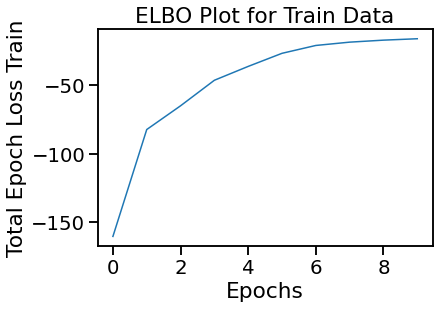

In [0]:
import matplotlib.pyplot as plt

plt.plot(train_elbo)
plt.xlabel("Epochs")
plt.ylabel("Total Epoch Loss Train")

plt.title("ELBO Plot for Train Data")

### Initializaing Saved Model

In [0]:
######LOADING THE SAVED MODEL#############
network_path = "/trained_model.save"

vae=CVAE(use_cuda=USE_CUDA)
vae.load_state_dict(torch.load(network_path))

<All keys matched successfully>

## Visualizing the reconstruction accuracy of VAE

Explaination: [2 cells] Checking and comparing original image with the one reconstructed from decoder

In [0]:
import warnings
warnings.filterwarnings("ignore")

data_iter = iter(data_loaders["train"])

xs, ys = next(data_iter)
print(xs.shape, ys.shape)
if USE_CUDA:
    xs = xs.cuda()
    ys = ys.cuda()

# Call to Reconstruct the Images from the Decoder
rs = vae.reconstruct_image(xs, ys)

if USE_CUDA:
    xs = xs.cpu()
    rs = rs.cpu()
# Original Image
originals = xs.numpy().reshape(-1, 64,64)

# Reconstructed Image from VAE
recons = rs.reshape(-1,64,64)

torch.Size([256, 4096]) torch.Size([256, 6])


In [0]:
# f(x) plots the given image possibilities that is its variation observed with a given label which here is shape
def f(x):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(originals[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    ax1 = fig.add_subplot(122)
    plt.imshow(recons[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    
interact(f, x=widgets.IntSlider(min=0, max=xs.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='x', max=255), Output()), _dom_classes=('widget-interact'…

<function __main__.f>

Explaination: [1 Cell] Sampled Images of the datset- All possible combination of dsprite images
(Nothing to do with encoder-decoder or CVAE or anything)

In [0]:
y_names = ['shape', 'scale', 'orientation', 'posX', 'posY']
y_shapes = np.array((3,6,40,32,32))
img_dict = {}

for i, img in enumerate(imgs_sampled):
     img_dict[tuple(labels_sampled[i])] = img

# print(img_dict)
def find_in_dataset(shape, scale, orient, posX, posY):
  fig = plt.figure()
  img = img_dict[(0, shape, scale, orient, posX, posY)]
  plt.imshow(img.reshape(64,64), cmap='Greys_r', interpolation='nearest')
  plt.axis('off')

interact(find_in_dataset, 
         shape=widgets.IntSlider(min=0, max=2, step=1, value=0),
         scale=widgets.IntSlider(min=0, max=5, step=1, value=0),
         orient=widgets.IntSlider(min=0, max=39, step=1, value=0),
         posX=widgets.IntSlider(min=0, max=31, step=1, value=0),
         posY=widgets.IntSlider(min=0, max=31, step=1, value=0))

interactive(children=(IntSlider(value=0, description='shape', max=2), IntSlider(value=0, description='scale', …

<function __main__.find_in_dataset>

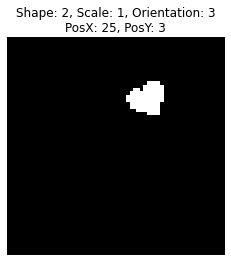

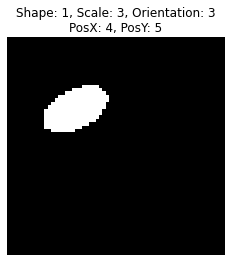

In [0]:
def get_specific_data(args=dict(), cuda=False):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        cuda - bool to indicate whether the output should be placed on GPU
    '''
    
    names_dict = {'shape': 1, 'scale': 2, 'orientation': 3, 'posX': 4, 'posY': 5}
    selected_ind = np.ones(imgs.shape[0], dtype=bool)
    for k,v in args.items():
        col_id = names_dict[k]
        selected_ind = np.bitwise_and(selected_ind, labels[:, col_id] == v)
    # print(selected_ind)
    ind = np.random.choice(np.arange(imgs.shape[0])[selected_ind])
    # print(ind)
    x = torch.from_numpy(imgs[ind].reshape(1,64**2).astype(np.float32))
    y = torch.from_numpy(labels[ind].reshape(1,6).astype(np.float32))
    if not cuda:
        return x,y
    x = x.cuda()
    y = y.cuda()
    return x,y

def plot_image(x):
    """
    helper to plot dSprites images
    """
    x = x.cpu()
    plt.figure()
    plt.imshow(x.reshape(64,64), interpolation='nearest', cmap='Greys_r')
    plt.axis('off')

def see_specific_image(args=dict(), verbose=True):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        verbose - bool to indicate whether the full class label should be written 
                    as the title of the plot
    '''
    x,y = get_specific_data(args, cuda=False)
    plot_image(x)
    if verbose:
        string = ''
        for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
            string += '%s: %d, ' % (s, int(y[0][i+1]))
            if i == 2:
                string = string[:-2] + '\n'
        plt.title(string[:-2], fontsize=12)

    
def compare_to_density(original, recons):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array of multiple recon images
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(torch.mean(recons.cpu(), 0).reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstructions')

#See random image
see_specific_image()
#See specific image        
see_specific_image({'shape': 1, 'scale': 3, 'orientation': 3, 'posX': 4, 'posY': 5})

In [0]:
label_dims = vae.label_shape
label_dim_offsets = np.cumsum(label_dims)
label_dim_offsets

array([  1,   4,  10,  50,  82, 114])

## Structural Causal Model

In [0]:
#Explaination: While creating object, takes as input the mu, sigma values generated from an encoder
class SCM():
    """
    Structural causal model
    
    args: 
      vae: instance of vae
      mu: loc of q(z|x) given by the vae encoder
      sigma: scale of q(z|x) given by the vae encoder
    
    """
    def __init__(self, vae, mu, sigma):
        """
        Constructor
        
        Intializes :
          image dimensions - 4096(64*64), 
          z dimensions: size of the tensor representing the latent random variable z, 
          label dimensions: 114 labels y that correspond to an image(one hot encoded)
          f(x) = p(x|y,z)
          Noise variables in the model N_#
        """
        self.vae = vae
        self.image_dim = vae.image_dim
        self.z_dim = vae.z_dim
        # these are used for f_X
        self.label_dims = vae.label_shape
        
        def f_X(Y, Z, N):
            """
            Generating one hots for the factors
            """ 
            zs = Z.cuda()
            # convert the labels to one hot
            ys = [torch.tensor([0])]
            ys.append(torch.nn.functional.one_hot(torch.round(Y[0]).to(torch.long), int(self.label_dims[1])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[1]).to(torch.long), int(self.label_dims[2])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[2]).to(torch.long), int(self.label_dims[3])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[3]).to(torch.long), int(self.label_dims[4])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[4]).to(torch.long), int(self.label_dims[5])))
            ys = torch.cat(ys).to(torch.float32).reshape(1,-1).cuda()
            p = vae.decoder.forward(zs, ys)
            return (N < p.cpu()).type(torch.float)
        
        def f_Y(N):
            """
            Gumbel distribution - to model the distribution of the maximum of a number of samples
            m = Gumbel(torch.tensor([1.0]), torch.tensor([2.0])).sample() # sample from Gumbel distribution with loc=1, scale=2
            tensor([ 1.0124])
            
            https://pytorch.org/docs/stable/_modules/torch/distributions/gumbel.html
            """
            beta = 12
            indices = torch.tensor(np.arange(N.size(0))).to(torch.float32)
            smax = nn.functional.softmax(beta*N)
            argmax_ind = torch.sum(smax*indices)
            return argmax_ind
        
        def f_Z(N):
            """
            Z ~ Normal(mu, sigma) 
            """
            return N * sigma + mu
        
        def model(noise): 
            """
            The model corresponds to a generative process
            
            args: noise variables
            return: X(image), Y(labels), Z(latents) 
            """
            N_X = pyro.sample( 'N_X', noise['N_X'].to_event(1) )
            # denoted using the index in the sequence 
            # that they are stored in as vae.label_names:
            # ['shape', 'scale', 'orientation', 'posX', 'posY']
            N_Y_1 = pyro.sample( 'N_Y_1', noise['N_Y_1'].to_event(1) )
            N_Y_2 = pyro.sample( 'N_Y_2', noise['N_Y_2'].to_event(1) )
            N_Y_3 = pyro.sample( 'N_Y_3', noise['N_Y_3'].to_event(1) )
            N_Y_4 = pyro.sample( 'N_Y_4', noise['N_Y_4'].to_event(1) )
            N_Y_5 = pyro.sample( 'N_Y_5', noise['N_Y_5'].to_event(1) )
            
            # Z ~ Normal(Nx_mu, Nx_sigma)              
            N_Z = pyro.sample( 'N_Z', noise['N_Z'].to_event(1) )
            Z = pyro.sample('Z', dist.Normal( f_Z( N_Z ), 1e-1).to_event(1) )
       
            Y_1 = pyro.sample('Y_1', dist.Normal( f_Y(N_Y_1), 1e-2) )
            Y_2 = pyro.sample('Y_2', dist.Normal( f_Y(N_Y_2), 1e-1) )
            Y_3 = pyro.sample('Y_3', dist.Normal( f_Y(N_Y_3), 1e-1) )
            Y_4 = pyro.sample('Y_4', dist.Normal( f_Y(N_Y_4), 1e-1) )
            Y_5 = pyro.sample('Y_5', dist.Normal( f_Y(N_Y_5), 1e-1) )
            
            
            # X ~ p(x|y,z) = bernoulli(loc(y,z))             
            X = pyro.sample('X', dist.Normal( f_X( (Y_1, Y_2, Y_3,Y_4,Y_5), Z, N_X ), 1e-2).to_event(1))
            
            # return noise and variables
            noise_samples = N_X, (N_Y_1, N_Y_2, N_Y_3, N_Y_4, N_Y_5), N_Z
            variable_samples = X, (Y_1, Y_2, Y_3, Y_4, Y_5), Z
            return variable_samples, noise_samples
        
        self.model = model
        #Initialize all noise variables in the model         
        self.init_noise = {
            'N_X'   : dist.Uniform(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)),
            'N_Z'   : dist.Normal(torch.zeros(vae.z_dim), torch.ones(vae.z_dim)),
            'N_Y_1' : dist.Uniform(torch.zeros(self.label_dims[1]),torch.ones(self.label_dims[1])),
            'N_Y_2' : dist.Uniform(torch.zeros(self.label_dims[2]),torch.ones(self.label_dims[2])),
            'N_Y_3' : dist.Uniform(torch.zeros(self.label_dims[3]),torch.ones(self.label_dims[3])),
            'N_Y_4' : dist.Uniform(torch.zeros(self.label_dims[4]),torch.ones(self.label_dims[4])),
            'N_Y_5' : dist.Uniform(torch.zeros(self.label_dims[5]),torch.ones(self.label_dims[5]))            
        }
        
    def update_noise_svi(self, obs_data, intervened_model=None):
        """
        Use svi to find out the mu, sigma of the distributions for the 
        condition outlined in obs_data
        """
        
        def guide(noise):
            """
            The guide serves as an approximation to the posterior p(z|x). 
            The guide provides a valid joint probability density over all the 
            latent random variables in the model.
            
            https://pyro.ai/examples/svi_part_i.html
            """
            # create params with constraints
            mu = {
                'N_X': pyro.param('N_X_mu', 0.5*torch.ones(self.image_dim),constraint = constraints.interval(0., 1.)),
                'N_Z': pyro.param('N_Z_mu', torch.zeros(self.z_dim),constraint = constraints.interval(-3., 3.)),
                'N_Y_1': pyro.param('N_Y_1_mu', 0.5*torch.ones(self.label_dims[1]),constraint = constraints.interval(0., 1.)),
                'N_Y_2': pyro.param('N_Y_2_mu', 0.5*torch.ones(self.label_dims[2]),constraint = constraints.interval(0., 1.)),
                'N_Y_3': pyro.param('N_Y_3_mu', 0.5*torch.ones(self.label_dims[3]),constraint = constraints.interval(0., 1.)),
                'N_Y_4': pyro.param('N_Y_4_mu', 0.5*torch.ones(self.label_dims[4]),constraint = constraints.interval(0., 1.)),
                'N_Y_5': pyro.param('N_Y_5_mu', 0.5*torch.ones(self.label_dims[5]),constraint = constraints.interval(0., 1.))
                }
            sigma = {
                'N_X': pyro.param('N_X_sigma', 0.1*torch.ones(self.image_dim),constraint = constraints.interval(0.0001, 0.5)),
                'N_Z': pyro.param('N_Z_sigma', torch.ones(self.z_dim),constraint = constraints.interval(0.0001, 3.)),
                'N_Y_1': pyro.param('N_Y_1_sigma', 0.1*torch.ones(self.label_dims[1]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_2': pyro.param('N_Y_2_sigma', 0.1*torch.ones(self.label_dims[2]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_3': pyro.param('N_Y_3_sigma', 0.1*torch.ones(self.label_dims[3]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_4': pyro.param('N_Y_4_sigma', 0.1*torch.ones(self.label_dims[4]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_5': pyro.param('N_Y_5_sigma', 0.1*torch.ones(self.label_dims[5]),constraint = constraints.interval(0.0001, 0.5))
                }
            for noise_term in noise.keys():
                pyro.sample(noise_term, dist.Normal(mu[noise_term], sigma[noise_term]).to_event(1))
        
        # Condition the model
        if intervened_model is not None:
          obs_model = pyro.condition(intervened_model, obs_data)
        else:
          obs_model = pyro.condition(self.model, obs_data)
          
        pyro.clear_param_store()

        # Once we’ve specified a guide, we’re ready to proceed to inference. 
        # Now, this an optimization problem where each iteration of training takes  
        # a step that moves the guide closer to the exact posterior 
        
        # https://arxiv.org/pdf/1601.00670.pdf
        svi = SVI(
            model= obs_model,
            guide= guide,
            optim= SGD({"lr": 1e-5, 'momentum': 0.1}),
            loss=Trace_ELBO(retain_graph=True)
        )
        
        num_steps = 1500
        samples = defaultdict(list)
        for t in range(num_steps):
            loss = svi.step(self.init_noise)
            for noise in self.init_noise.keys():
                mu = '{}_mu'.format(noise)
                sigma = '{}_sigma'.format(noise)
                samples[mu].append(pyro.param(mu).detach().numpy())
                samples[sigma].append(pyro.param(sigma).detach().numpy())
        means = {k: torch.tensor(np.array(v).mean(axis=0)) for k, v in samples.items()}
        
        # update the inferred noise
        updated_noise = {
            'N_X'  : dist.Normal(means['N_X_mu'], means['N_X_sigma']),
            'N_Z'  : dist.Normal(means['N_Z_mu'], means['N_Z_sigma']),
            'N_Y_1': dist.Normal(means['N_Y_1_mu'], means['N_Y_1_sigma']),
            'N_Y_2': dist.Normal(means['N_Y_2_mu'], means['N_Y_2_sigma']),
            'N_Y_3': dist.Normal(means['N_Y_3_mu'], means['N_Y_3_sigma']),
            'N_Y_4': dist.Normal(means['N_Y_4_mu'], means['N_Y_4_sigma']),
            'N_Y_5': dist.Normal(means['N_Y_5_mu'], means['N_Y_5_sigma']),
        }
        return updated_noise
        
    def __call__(self):
        return self.model(self.init_noise)

### Sanity check 1 
Making sure VAE works

Explaination: Generating single image and reconstructing it using sampling

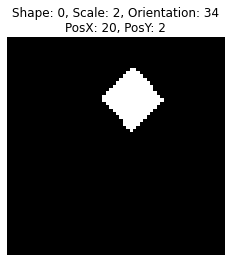

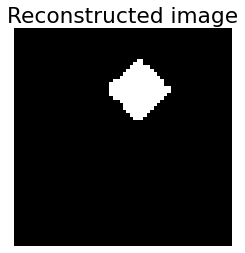

In [0]:
# Generate an instance of dSprites image 
ox, y = get_specific_data(cuda=True)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
mu, sigma = vae.encoder.forward(ox,vae.remap_y(y))
# Feed these params to our custom SCM
scm = SCM(vae, mu.cpu(), sigma.cpu())
string = ''
for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
    string += '%s: %d, ' % (s, int(y[0][i+1]))
    if i == 2:
        string = string[:-2] + '\n'
plot_image(ox)
plt.title(string[:-2], fontsize=12)
plt.show()
# Check for reconstruction
zs = dist.Normal(mu.cpu(), sigma.cpu()).to_event(1).sample()
loc = vae.decoder.forward(zs.cuda(), vae.remap_y(y))
recon = dist.Bernoulli(loc).to_event(1).sample()
recon = recon.reshape(64,64)
plt.imshow(recon.cpu(), cmap='Greys_r',  interpolation='nearest')
plt.axis('off')
plt.title('Reconstructed image')
plt.show()

### Sanity check 2

####To check if the decoder is able to generate the image if the latents are changed: [Here we are changin the shape label first and then the orientation]
#### To achieve this we manually change the labels in the code and run it through the decoder and check for reconstruction

top original image with no change:  tensor([[ 0.,  0.,  3., 11., 12., 27.]], device='cuda:0')
Middle with change in shape:  tensor([[ 0.,  1.,  3., 11., 12., 27.]], device='cuda:0')
bottom with change in Orientation:  tensor([[ 0.,  1.,  3.,  0., 12., 27.]], device='cuda:0')


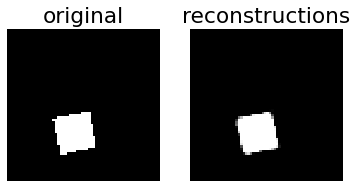

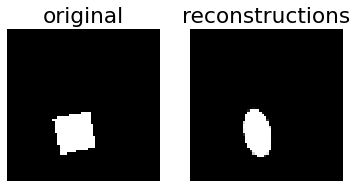

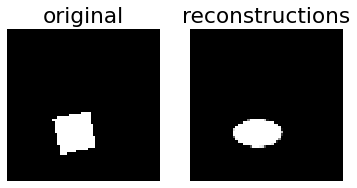

In [0]:
original, y_original = get_specific_data(cuda=True)
print('top original image with no change: ',y_original)
mu, sigma = vae.encoder.forward(original,vae.remap_y(y_original))
B = 100
#Explaination: here zs is being sampled 100 times with new values from distribution
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
#Explaination: here ys is being repeatedly 100 times assigned the same value
ys = torch.cat([vae.remap_y(y_original) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)

y_new = torch.tensor(y_original)

y_new[0,1] = (y_original[0,1] + 1) % 2
print('Middle with change in shape: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)


y_new[0,3] = (y_original[0,3] + 1) % 2
print('bottom with change in Orientation: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)


### SCM Reconstruction

In [0]:
#Getting original image
scm_x, scm_y = get_specific_data(cuda=True)
scm_cond_data = {}
for i in range(1, 6):
    scm_cond_data["Y_{}".format(i)] = torch.tensor(scm_y[0,i].cpu()).to(torch.float32)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
scm_mu, scm_sigma = vae.encoder.forward(scm_x,vae.remap_y(scm_y))
# Feed these params to our custom SCM
scm = SCM(vae, scm_mu.cpu(), scm_sigma.cpu())
#infer Noise variables from original image
scm_cond_noise = scm.update_noise_svi(scm_cond_data) 
print(scm_cond_data)

NameError: ignored

In [0]:
#Sampling prediction on 1000 images
scm_rxs = []
for i in range(1000):
     (scm_rx,scm_ry,_), _= scm.model(scm_cond_noise)
     scm_rxs.append(scm_rx)
compare_to_density(scm_x, torch.cat(scm_rxs))
_ =plt.suptitle("SCM Reconstructed Image", fontsize=18, fontstyle='italic')

### SCM Conditioning

In [0]:
#Getting original image
scm_x, scm_y = get_specific_data(cuda=True)
scm_cond_data = {}
for i in range(1, 6):
    scm_cond_data["Y_{}".format(i)] = torch.tensor(scm_y[0,i].cpu()).to(torch.float32)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
scm_mu, scm_sigma = vae.encoder.forward(scm_x,vae.remap_y(scm_y))
# Feed these params to our custom SCM
scm = SCM(vae, scm_mu.cpu(), scm_sigma.cpu())
#infer Noise variables from original image
scm_cond_noise = scm.update_noise_svi(scm_cond_data) 
print(scm_cond_data)

In [0]:
# Conditioning on Scale
conditioned_model = pyro.condition(scm.model, data={
    # "Y_1": torch.tensor(2.),
    "Y_2": torch.tensor(5.),
    # "Y_3": torch.tensor(2.),
    # "Y_4": torch.tensor(5.),
    # "Y_5": torch.tensor(25.),
})
#Sampling prediction on 1000 images
scm_rxs = []
for i in range(1000):
     (scm_rx,scm_ry,_), _= conditioned_model(scm_cond_noise)
     scm_rxs.append(scm_rx)
compare_to_density(scm_x, torch.cat(scm_rxs))
_ =plt.suptitle("SCM conditioned on scale", fontsize=18, fontstyle='italic')

### SCM Intervention

In [0]:
#Getting original image
scm_x, scm_y = get_specific_data(cuda=True)
scm_cond_data = {}
for i in range(1, 6):
    scm_cond_data["Y_{}".format(i)] = torch.tensor(scm_y[0,i].cpu()).to(torch.float32)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
scm_mu, scm_sigma = vae.encoder.forward(scm_x,vae.remap_y(scm_y))
# Feed these params to our custom SCM
scm = SCM(vae, scm_mu.cpu(), scm_sigma.cpu())
#infer Noise variables from original image
scm_cond_noise = scm.update_noise_svi(scm_cond_data) 
print(scm_cond_data)

In [0]:
# Intervening on PositionX and PositionY
intervened_model = pyro.do(scm.model, data={
    # "Y_1": torch.tensor(2.),
    # "Y_2": torch.tensor(5.),
    # "Y_3": torch.tensor(2.),
    "Y_4": torch.tensor(31.),
    "Y_5": torch.tensor(31.),
})
#Sampling prediction on 1000 images
scm_rxs = []
for i in range(1000):
     (scm_rx,scm_ry,_), _= intervened_model(scm_cond_noise)
     scm_rxs.append(scm_rx)
compare_to_density(scm_x, torch.cat(scm_rxs))
_ =plt.suptitle("SCM intervened on positionX and positionY", fontsize=18, fontstyle='italic')

### SCM Counterfactuals

##### Original image

Original Labels: tensor([[ 0.,  0.,  3., 16.,  0., 30.]], device='cuda:0')


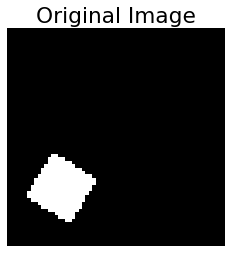

In [0]:
# Generate an instance of dSprites image 
x_original, y_original = get_specific_data(cuda=True)
print('Original Labels:', y_original)
plot_image(x_original)
plt.title("Original Image")
plt.show()

In [0]:
#Creating a conditional variable of Noise variables for the abduction step
original_cond_data = {}
for i in range(1, 6):
    original_cond_data["Y_{}".format(i)] = torch.tensor(y_original[0,i].cpu()).to(torch.float32)
print("original_cond_data:", original_cond_data)

original_cond_data: {'Y_1': tensor(0.), 'Y_2': tensor(3.), 'Y_3': tensor(16.), 'Y_4': tensor(0.), 'Y_5': tensor(30.)}


##### Abduction Step

In [0]:
# Pass it through VAE to get q(z|x) => N(mu, sigma)
mu, sigma = vae.encoder.forward(x_original,vae.remap_y(y_original))
# Feed these params to our custom SCM
scm = SCM(vae, mu.cpu(), sigma.cpu())
#infer Noise variables from original image
infer_cond_noise = scm.update_noise_svi(original_cond_data) 
print(infer_cond_noise)

{'N_X': Normal(loc: torch.Size([4096]), scale: torch.Size([4096])), 'N_Z': Normal(loc: torch.Size([50]), scale: torch.Size([50])), 'N_Y_1': Normal(loc: torch.Size([3]), scale: torch.Size([3])), 'N_Y_2': Normal(loc: torch.Size([6]), scale: torch.Size([6])), 'N_Y_3': Normal(loc: torch.Size([40]), scale: torch.Size([40])), 'N_Y_4': Normal(loc: torch.Size([32]), scale: torch.Size([32])), 'N_Y_5': Normal(loc: torch.Size([32]), scale: torch.Size([32]))}


In [0]:
# Printing the inferred noise variables
cf_noise_data = {}
for term, d in infer_cond_noise.items():
  cf_noise_data[term] = d.loc
print(cf_noise_data)

{'N_X': tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]), 'N_Z': tensor([ 7.2131e-04, -9.9972e-04, -4.6039e-04,  2.9603e-04,  1.6602e-04,
         1.2667e-04,  7.5241e-04, -2.8542e-04, -1.8308e-04, -5.9955e-04,
        -2.8085e-05,  8.4931e-04,  7.8631e-05, -1.9801e-04,  5.9767e-04,
         6.9774e-04,  2.7409e-04, -9.8322e-04,  7.1390e-05, -4.0704e-04,
         1.2645e-04, -3.4702e-04, -4.2166e-04,  1.0220e-03, -1.1298e-04,
         6.4532e-04, -5.7281e-06,  8.1240e-04,  1.6634e-04,  4.6125e-04,
         1.3454e-03,  4.9661e-05, -2.6115e-04,  4.1574e-04, -7.4073e-04,
        -6.9824e-04, -4.1328e-05,  5.8212e-05, -7.0959e-05, -4.0933e-04,
        -7.9321e-04,  5.7013e-04,  2.3366e-05,  3.9415e-05,  6.8323e-04,
        -3.4395e-05,  5.2065e-04, -9.1319e-04,  1.0772e-04, -3.7173e-04]), 'N_Y_1': tensor([0.8002, 0.3566, 0.2770]), 'N_Y_2': tensor([0.4410, 0.4709, 0.5067, 0.5370, 0.5346, 0.5103]), 'N_Y_3': tensor([0.4927, 0.4913, 0.4990, 0.5063, 0.5054, 0.5029, 0.5111, 0.5190

##### Action Step

In [0]:
# intervening on the SCM model
cf_intervened_model = pyro.do(scm.model, data={
    "Y_1": torch.tensor(2.),
    # "Y_2": torch.tensor(2.),
    # "Y_3": torch.tensor(2.),
    # "Y_4": torch.tensor(5.),
    # "Y_5": torch.tensor(25.),
})

##### Prediction step 

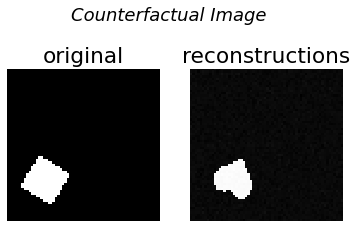

In [0]:
#Predicting single image
(cf_rx,cf_ry,_), _ = cf_intervened_model(infer_cond_noise)
compare_to_density(x_original, cf_rx)
_ =plt.suptitle("Counterfactual Image", fontsize=18, fontstyle='italic')

In [0]:
# Prediction step with Sampling will produce a "Blur" Image as the Mean values are considered.

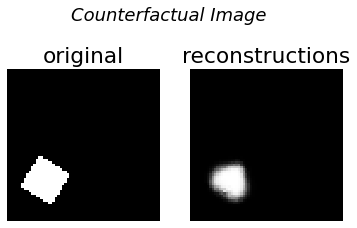

In [0]:
#Sampling prediction on 1000 images
cf_rxs = []
for i in range(1000):
     (cf_rx,cf_ry,_), _= cf_intervened_model(infer_cond_noise)
     cf_rxs.append(cf_rx)
compare_to_density(x_original, torch.cat(cf_rxs))
_ =plt.suptitle("Counterfactual Image", fontsize=18, fontstyle='italic')